In [11]:
%run -i Dataset_cleanup/cleanup_clinical.py

Clinical data set imported


 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 



 Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'gleasonscore'
 'histologicaltype' 'numberoflymphnodes' 'pathologyTstage'
 'radiationtherapy' 'residualtumor' 'vitalstatus'] 


Variables that are known at the time of diagnosis:
 ['dateofinitialpathologicdiagnosis' 'psavalue' 'race' 'yearstobirth']

Dimensions of clinical dataframe: (499, 7)


In [12]:
%run -i Dataset_cleanup/cleanup_gene_counts.py

Gene Counts data set imported

Dimension of DataFrame: (497, 20501)


### Data wrangling

In [14]:
"""The Clinical data (including metastasis label) have a multitude of missing items."""
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y[y.isnull()]
y_labels = y[y.notnull()]

print("\nLabeled observations:",y_labels.shape[0],"\nUnlabeled observations removed:",not_labeled.shape[0])


Total observations in original dataset: 499

Labeled observations: 426 
Unlabeled observations removed: 73


In [15]:
clinical = clinical.loc[y_labels.index]  #filter only observations where metastasis state is known
print("Filtering out missing metastasis state labels left",clinical.shape[0],"observations")

clin_df = clinical.dropna(inplace = False) # Remove all observations where clinical data is missing
print("Removing NaN rows leaves ",clin_df.shape[0]," observations in the feature set.") 

y_clin = y_labels.loc[clin_df.index] #remove metastasis labels where no clinical data now exists due to NaN removal.

Filtering out missing metastasis state labels left 426 observations
Removing NaN rows leaves  359  observations in the feature set.


In [16]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[list(y_labels.index)]  #Only observations that also have a known metastasis state are kept.
X.dropna(axis=0, inplace=True)

In [17]:
"""Ensure target labels correspond to an observation in X"""
y = y_labels[X.index] #only labels that are in X are kept.  

In [18]:
"""Test on DataFrame"""
def duplicate_TCGA_ID_test(X) :
    seen = set()
    uniq = []
    duplicates = []
    for x in X.index:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
        else:
            duplicates.append(x)
    if len(duplicates) > 0 :
        print("Error in data set arrangement")
    else :
        print("TPM count dataset contains",X.shape[0],"uniquely barcoded observations.")

duplicate_TCGA_ID_test(X)

TPM count dataset contains 424 uniquely barcoded observations.


#### DataFrames for project:
**'Clinical'** : feature variables that would be known at time of diagnosis.  Observations limited to those where a label exists for metastasis state. (associated with y_labels) 

**'clin_df'** : Clinical data with NaN dropped. (associated with y_clin) 

**'y_labels'** : all observations of metastasis state regardless of missing clinical or gene count data.

**y_clin** : all target labels where clinical information is not NaN.

**gene_counts** : unscaled, untransformed estimated transcript abundance counts uploaded from TCGA portal (RSEM)

**X_all** : raw estimated abundance transformed to estimated transcripts per million transcripts (TPM).  Observations include all in data set, regardless of whether a label for metastasis state has also been recorded for the patient. 

**X** : Observations from X_all are limited to those that also have a finite target label.  

**X_scaled** : All TPM counts have been transformed to mean = 0, standard unit variance.

**y** : all y_labels where observation exists for X

## Benchmark Analysis of initial clinical presentation for  predictors of metastasis

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, accuracy_score, f1_score, classification_report

In [20]:
recaller = make_scorer(recall_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1')
accuracy = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False, needs_threshold=False)
f1_scorer = make_scorer(f1_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1')
clf = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=None,
                            min_samples_split=30,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            random_state=None,
                            max_leaf_nodes=None,
                            class_weight='balanced', #avoids the classifier being rewarded for choosing the most prevelant class each instance (n0)
                            presort=False)
recall_vals = cross_val_score(clf, clin_df, y_clin, scoring=recaller, cv=5)
accuracy_vals = cross_val_score(clf, clin_df, y_clin, scoring=accuracy, cv=5)
print('Recall_n1:  ',recall_vals.mean())

print('\nModel Accuracy score:  ',accuracy_vals.mean())
print("\nNull error rate for metastasis call:  ",(sum(y_clin == 'n1') / len(y_clin)))

Recall_n1:   0.465384615385

Model Accuracy score:   0.542113640749

Null error rate for metastasis call:   0.16991643454


### Feature Reduction

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

In [11]:
selector = SelectKBest(f_classif, k = 424)
selector.fit(X, y_labels_NA_gc_dropped)
X_k = selector.transform(X)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9292  9419  9421  9423  9495 10092 11101 11929 12028
 12488 12527 12584 12593 12599 12601 12606 12635 12692 13749 13963 14015
 14129 14130 14131 14132 14726 14727 14729 15109 15111 15112 16536 16538
 16539 16541 16542 16543 16545 16546 16547 16548 16549 16550 16576 16605
 16608 16648 16668 16669 16670 16671 16672 16673 16674 16675 16676 16677
 16678 16679 16680 16681 16682 16683 16684 16685 16686 16687 16688 16689
 16690 16691 16692 16693 16694 16695 16696 16697 16698 16699 16700 16701
 16702 16703 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713
 16714 16715 16716 16717 16718 16720 16721 16722 16723 16724 16725 

In [12]:
print(X.shape)

(424, 20501)


In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=10, 
          copy=True, 
          whiten=False)

In [15]:
from sklearn.preprocessing import scale

In [16]:
#
X_scaled = scale(X_k)
X_pca = pca.fit(X_scaled).transform(X_scaled)

In [17]:
X_pca = pd.DataFrame(X_pca)

### Graphical Analysis of Feature Reduction with PCA

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
c_dict = {'n1' : 'red', 'n0' : 'blue'}
col_label = list(y_labels_NA_gc_dropped.replace(c_dict, inplace = False))

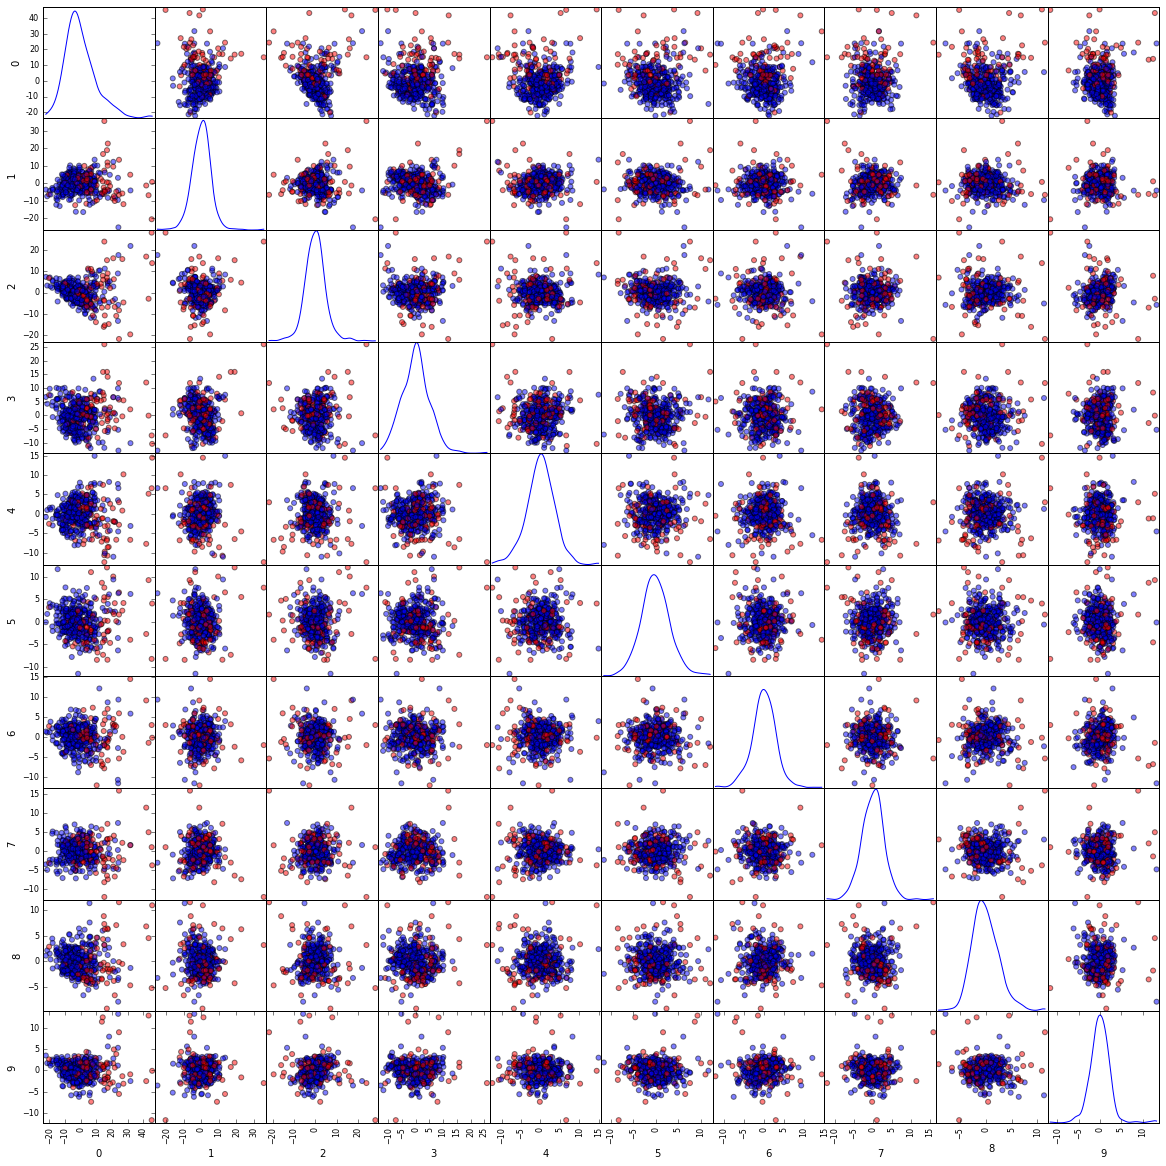

In [20]:
sm = pd.scatter_matrix(X_pca, alpha=0.5, figsize= (20,20), diagonal = 'kde', c = col_label, s = 100)

## Generate Models

### Test Train Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = X_pca
y = y_labels_NA_gc_dropped
print(X.shape, y.shape)

(424, 10) (424,)


In [23]:
train_k = round(len(y)*5 /6) #5/6 of set dedicated to training set
test_k = len(y) - train_k #1/6 of set dedicated to test set

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = 123,
                                                    stratify = y)

### SVM with Recursive Feature Elimination 

In [25]:
%run -i RFE_SVM/RFECV_SVM.py
print("\n",SVM_clf)

             precision    recall  f1-score   support

         n0       0.00      0.00      0.00       287
         n1       0.19      1.00      0.32        66

avg / total       0.03      0.19      0.06       353

Int64Index([0, 1, 3, 4, 5, 7, 8, 9], dtype='int64')
SVC(C=0.5, cache_size=200, class_weight={'n1': 0.95, 'n0': 0.05}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

 SVC(C=0.5, cache_size=200, class_weight={'n1': 0.95, 'n0': 0.05}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)


/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### AdaBoost

In [26]:
%run -i AdaBoost/adaboost.py
print("\n",ada_clf)

             precision    recall  f1-score   support

         n0       0.93      0.74      0.82       287
         n1       0.39      0.74      0.51        66

avg / total       0.83      0.74      0.76       353


 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight={'n1': 0.85, 'n0': 0.15},
            criterion='gini', max_depth=2, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=123)


### Random Forest

In [27]:
%run -i Random_Forest/RF.py

             precision    recall  f1-score   support

         n0       0.98      0.89      0.93       287
         n1       0.65      0.94      0.77        66

avg / total       0.92      0.90      0.90       353

RandomForestClassifier(bootstrap=True, class_weight={'n1': 0.95, 'n0': 0.05},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)


### Logistic Regression for Gleason Scores

In [28]:
%run -i LogReg_gleason/LogReg_GS.py

             precision    recall  f1-score   support

         n0       0.94      0.62      0.75       287
         n1       0.33      0.82      0.47        66

avg / total       0.82      0.66      0.70       353

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


## Voting Classifier

In [29]:
def Voter(X_train, y_train) :
    Vote_DF = pd.DataFrame({'y_labels': y_train, 
                            'RandomForest': RF_clf.predict(X_train), 
                            'AdaBoost': ada_clf.predict(X_train), 
                            'SVM' : SVM_clf.predict(selector.transform(X_train)),
                            'Gleason_LR' : Gleason_LR_clf.predict_proba(gleason.loc[y_train.index].reshape(-1,1))[:,1]}
                           )
    Vote_DF.replace({'n0': 0, 'n1':1}, inplace=True)
    Vote_DF['weighted_mean'] = Vote_DF.apply(lambda x: np.sum([x[0]*.2,
                                                               x[1]*.2,
                                                               x[2]*.5,
                                                               x[3]*.1]), axis = 1)
    print(Vote_DF.columns)
    #print(Vote_DF)
    print(Vote_DF.iloc[:,4:6])
    

Voter(X_train, y_train)

Index(['AdaBoost', 'Gleason_LR', 'RandomForest', 'SVM', 'y_labels',
       'weighted_mean'],
      dtype='object')
                y_labels  weighted_mean
clinical_index                         
TCGA-VN-A88R           0       0.201879
TCGA-EJ-5515           0       0.174298
TCGA-J4-A67M           0       0.174298
TCGA-EJ-5518           0       0.229176
TCGA-EJ-AB20           0       0.150352
TCGA-CH-5794           0       0.174298
TCGA-QU-A6IL           0       0.174298
TCGA-V1-A9O9           0       0.901879
TCGA-EJ-5509           0       0.174298
TCGA-HC-7752           0       0.174298
TCGA-CH-5746           0       0.174298
TCGA-ZG-A9L5           1       0.929176
TCGA-EJ-5494           0       0.174298
TCGA-G9-7525           0       0.174298
TCGA-KK-A6E4           0       0.174298
TCGA-KK-A8I7           0       0.229176
TCGA-V1-A9OX           0       0.201879
TCGA-V1-A9O7           0       0.429176
TCGA-HC-7210           0       0.174298
TCGA-EJ-8472           0       0.901879
TCGA-

## Test for the best model

In [30]:
print(classification_report(y_test,
                            clf.predict(gleason_test),
                            target_names = ['n0', 'n1']))

             precision    recall  f1-score   support

         n0       0.95      0.67      0.79        58
         n1       0.37      0.85      0.51        13

avg / total       0.84      0.70      0.74        71



In [31]:
print(classification_report(y_test,
                            SVM_clf.predict(selector.transform(X_test)),
                            target_names = ['n0', 'n1']))

             precision    recall  f1-score   support

         n0       0.00      0.00      0.00        58
         n1       0.18      1.00      0.31        13

avg / total       0.03      0.18      0.06        71



/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
print(classification_report(y_test,
                            RF_clf.predict(X_test),
                            target_names = ['n0', 'n1']))

             precision    recall  f1-score   support

         n0       0.95      0.91      0.93        58
         n1       0.67      0.77      0.71        13

avg / total       0.90      0.89      0.89        71



In [33]:
print(classification_report(y_test,
                            ada_clf.predict(X_test),
                            target_names = ['n0', 'n1']))

             precision    recall  f1-score   support

         n0       0.98      0.81      0.89        58
         n1       0.52      0.92      0.67        13

avg / total       0.90      0.83      0.85        71

